## Setup

In [ ]:
!pip install emoji

In [50]:
!pip install umap

  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3543 sha256=bda1897cb3d433cddd7bcd43b594e9a20ad8b1b893ff17637c5d9743510c73d5
  Stored in directory: /root/.cache/pip/wheels/15/f1/28/53dcf7a309118ed35d810a5f9cb995217800f3f269ab5771cb
Successfully built umap


In [51]:
!pip install imojify

In [25]:
import json
import emoji

In [ ]:
!pip install emoji

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Word2Vect w/ Emojis

## Mapping

In [27]:
emoji_mapping = {
    ':)': '😀',
    ':-)': '😀',
    ':(': '😞',
    ':-(': '😞',
    ':-/': '🫤',
    '<3': '❤️',
    'XD': '😆',
    'xD': '😆',
    'xd': '😆',
    ':D': '😄',
    ':O': '😲',
    ';)': '😉',
    ':P': '😜',
    '>:(': '😠',
    ':-*': '😘',
    ':*': '😘',
    'B)': '😎',
    '>:D': '😈',
    'O:)': '😇',
    ':|': '😐',
    ':S': '😖',
    ':X': '😶',
    '<(")': '🐦',
    '>:O': '😱',
    '\\o/': '🙌',
    '(^_^)/': '🌟',
    '(o_o)/': '🌜',
    '<>_<>': '🎮',
    '(>_<)': '😣',
    '(^_-)': '😄',
    '(^_^)b': '👍',
    '(~_^)': '😂',
    ':-D': '😁',
    ':|)': '😐',
    '>:)': '😏',
}

## Map emoticons to emoji

In [28]:
sentences = []
train_path = "/content/drive/MyDrive/COMET_data/paracomet/dialogue/samsum/dialog_train_split5_collated.json"

with open(train_path, 'r') as file:
        data = json.load(file)
        for key, value in data.items():
            for k, v in value.items():
                for inner_key, inner_value in v.items():
                    if inner_key == "sentence":
                        sentences.append(inner_value)

In [ ]:
def extract_emojis(text):
    return [char for char in text if char in emoji.EMOJI_DATA]

def substitute_emojis(text, emoji_mapping):
    for key, value in emoji_mapping.items():
        text = text.replace(key, value)
    return text

In [30]:
# map emoticons to emoji
mapped_dialogues = []

for s in sentences:
  mapped_dialogues.append(substitute_emojis(s, emoji_mapping))

## Train W2V model

In [42]:
import pickle
from gensim.models import Word2Vec

def preparing_data(data_path):
    if data_path:
        with open(data_path, "r", encoding="utf-8") as f:
            lines = f.readlines()
            train_data = [line.strip().split() for line in lines]
        return train_data
    else:
        print("Error path")

def train_model(size, window, min_count, workers, vocab_size, negative, epochs, train_data):
    # train model
    print("training word2vec")
    model = Word2Vec(
        train_data,
        vector_size=size,
        window=window,
        min_count=min_count,
        workers=workers,
        max_vocab_size=vocab_size,
        negative=negative,
        epochs=epochs  # Add epochs parameter
    )
    print("saving model")
    model.save("word2vecGIGI.bin")
    model.wv.save_word2vec_format("word2vec.txt")

# Assign values manually
dataset_path = "/content/drive/MyDrive/datasets/twitter_data.txt"
word2vec_size = 300
word2vec_window = 5
word2vec_min_count = 10
word2vec_workers = 4
word2vec_vocab_size = None
word2vec_negative = 5
word2vec_epochs = 20

train_data = preparing_data(dataset_path)
train_model(
    size=word2vec_size,
    window=word2vec_window,
    min_count=word2vec_min_count,
    workers=word2vec_workers,
    vocab_size=word2vec_vocab_size,
    negative=word2vec_negative,
    train_data=train_data,
    epochs=word2vec_epochs
)

training word2vec
saving model


In [43]:
model_path = "/content/word2vecGIGI.bin"
model = Word2Vec.load(model_path)

In [45]:
similar_words = model.wv.most_similar('😘', topn=10)
print("\n",similar_words,"\n")


 [('💕', 0.6058509349822998), ('😚', 0.6037052273750305), ('😙', 0.5728139877319336), ('💗', 0.5655301213264465), ('💋', 0.5646389722824097), ('💖', 0.5642983913421631), ('💓', 0.5405202507972717), ('💞', 0.5139450430870056), ('💘', 0.48827773332595825), ('💜', 0.477927565574646)] 



## Fine-tune on samsum

In [46]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt')

# Load your new dataset (a list of sentences)
new_sentences = mapped_dialogues

# Tokenize the sentences into lists of words
tokenized_sentences = [word_tokenize(sentence.lower()) for sentence in new_sentences]

# Update the vocabulary with the new dataset
model.build_vocab(tokenized_sentences, update=True)

# Fine-tune the model on the new dataset
model.train(tokenized_sentences, total_examples=model.corpus_count, epochs=model.epochs)

# Save the fine-tuned model
fine_tuned_model_path = '/content/drive/MyDrive/fine_tuned_word2vec_model.bin'
model.save(fine_tuned_model_path)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [49]:
similar_words = model.wv.most_similar('hiking', topn=20)
print("\n",similar_words,"\n")


 [('camping', 0.46685802936553955), ('hike', 0.44762393832206726), ('🏔', 0.4406657814979553), ('downtown', 0.4384947419166565), ('outdoors', 0.43639296293258667), ('swimming', 0.4256763756275177), ('seaside', 0.4190371036529541), ('amusement', 0.4159093201160431), ('gardens', 0.4104215204715729), ('🏖', 0.40977030992507935), ('orchard', 0.40135255455970764), ('skate', 0.4012800455093384), ('jogging', 0.40113651752471924), ('climbing', 0.3987942636013031), ('🚵', 0.39870285987854004), ('🎢', 0.39857131242752075), ('exploring', 0.3979824185371399), ('🎿', 0.3975323438644409), ('beach', 0.3972926139831543), ('edinburgh', 0.3966388404369354)] 



## PCA & Plotting in 2d space

In [52]:
emoji_embeddings_dict = {}

# Populate the dictionary with emoji embeddings
for emoji in emoji.EMOJI_DATA:
    if emoji in model.wv:
        emoji_embeddings_dict[emoji] = model.wv[emoji]

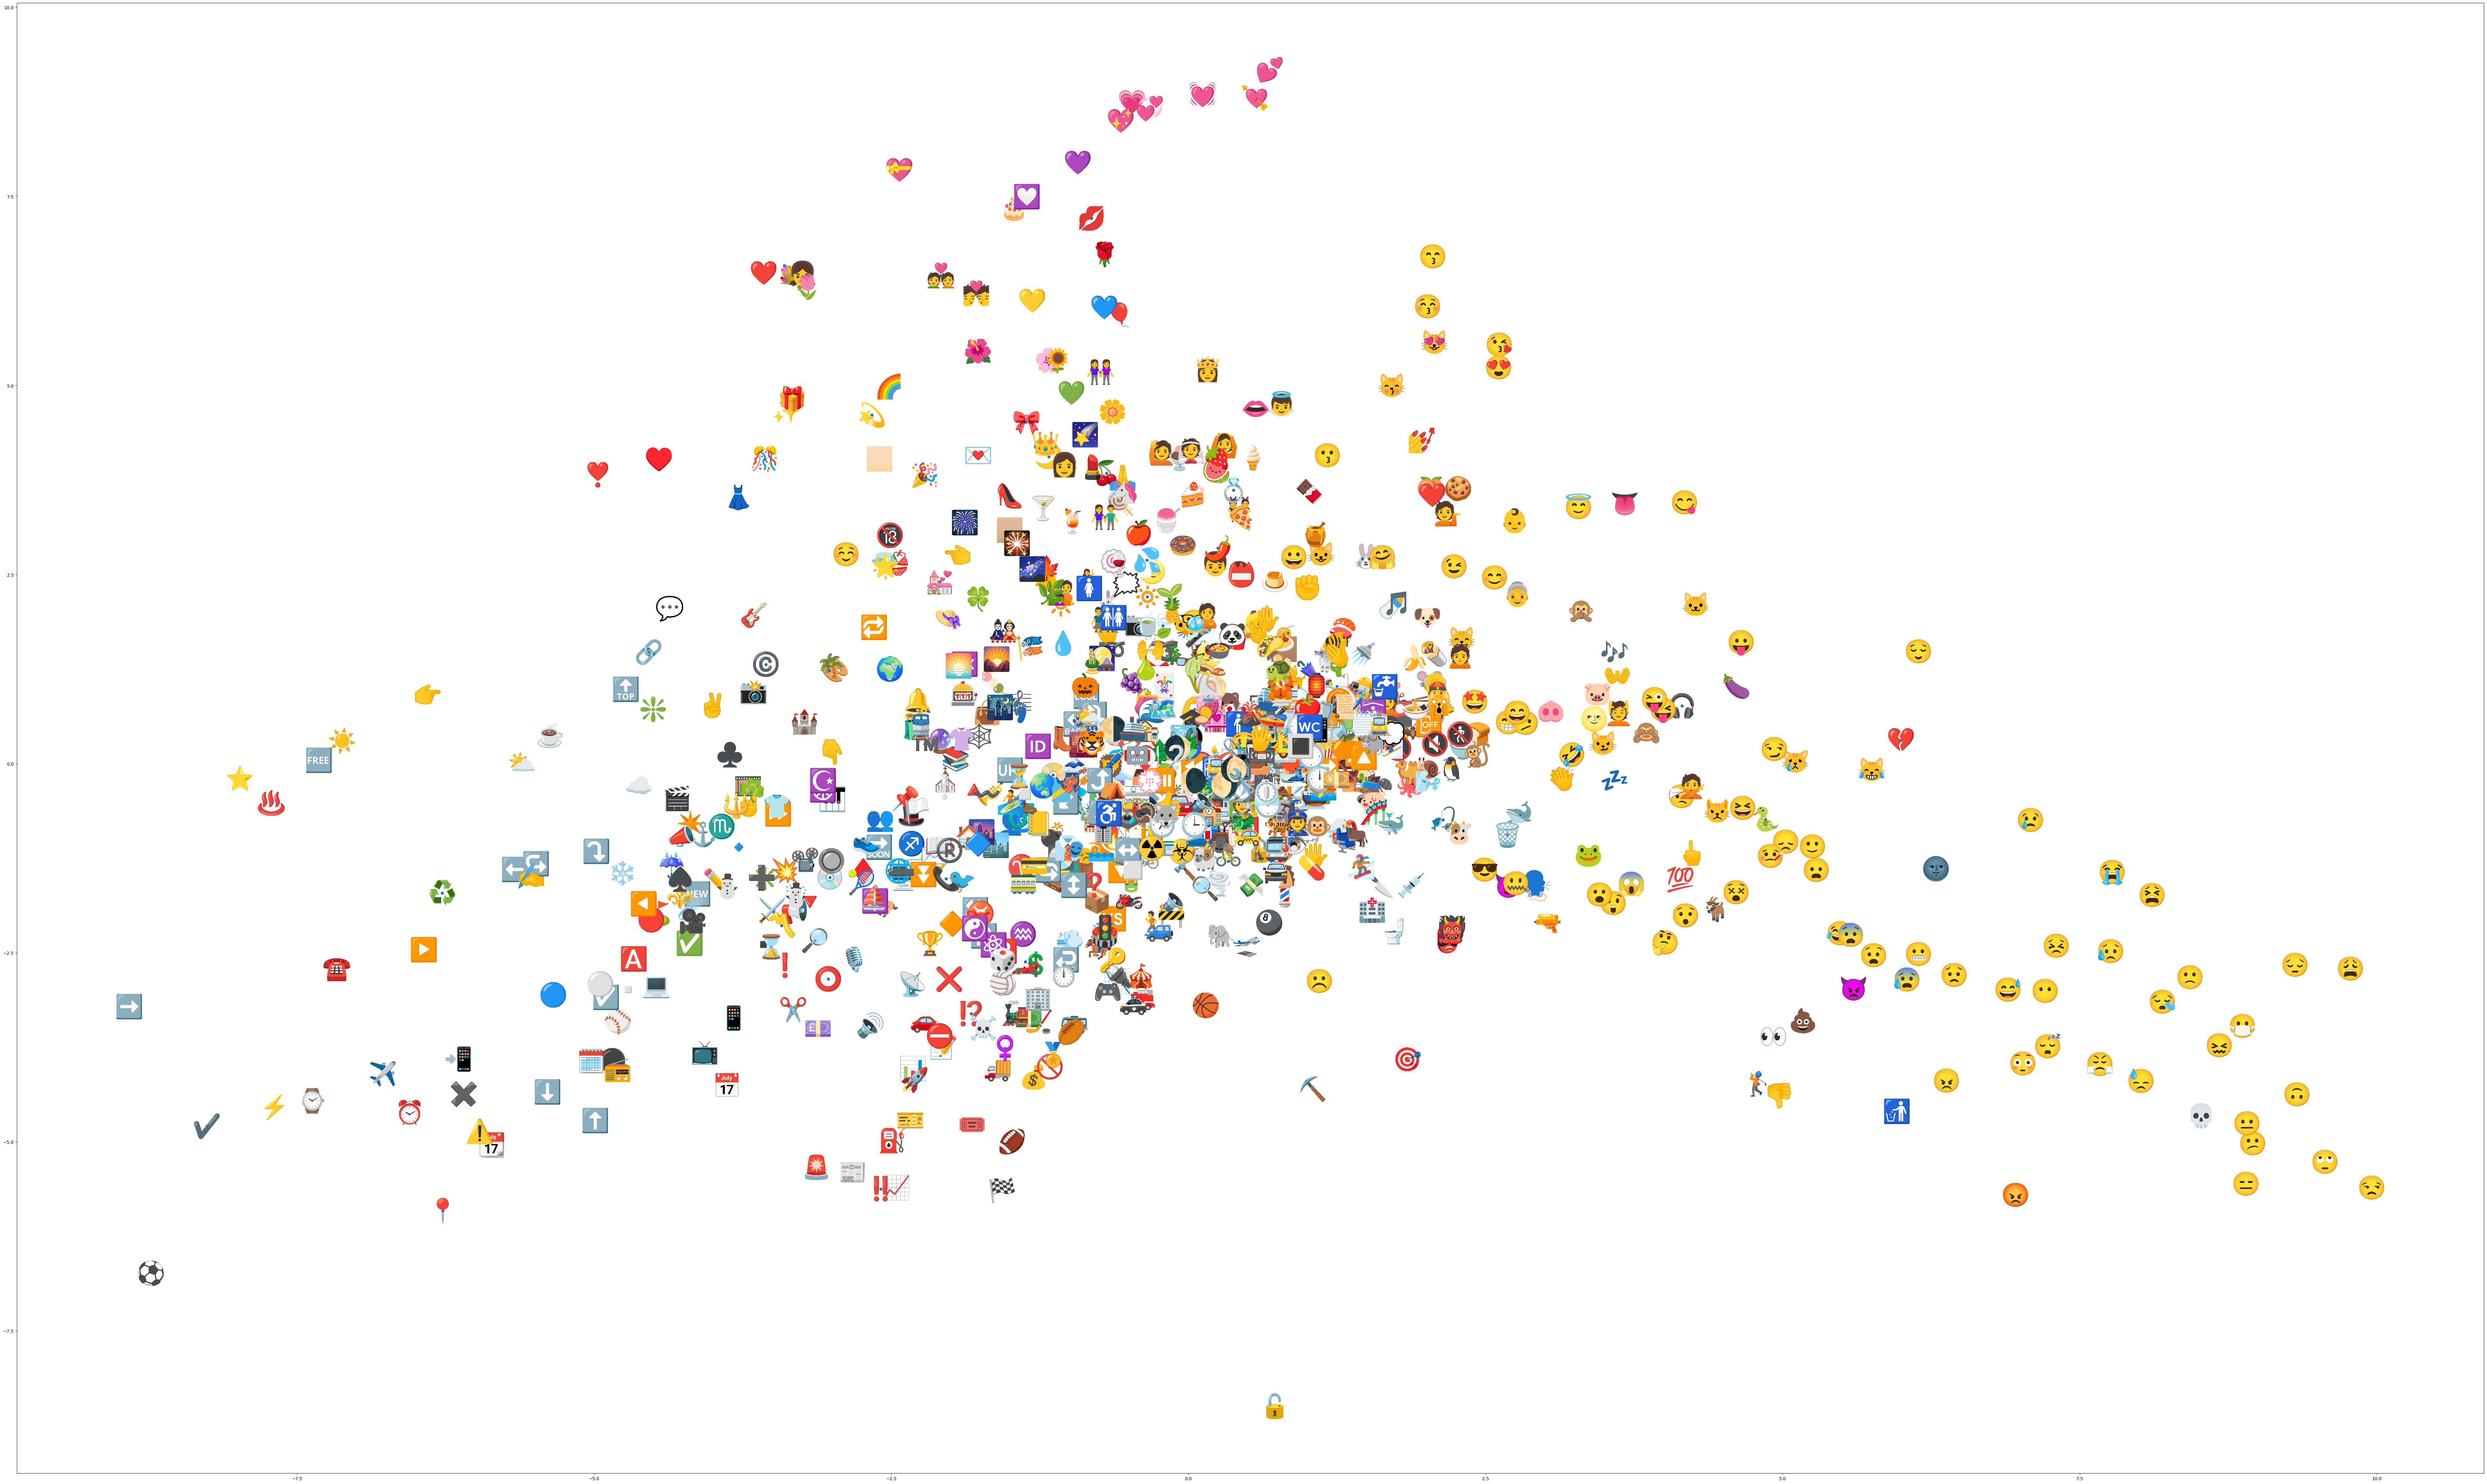

In [53]:
import numpy as np
from sklearn.decomposition import PCA
from imojify import imojify
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


def offset_image(cords, emoji, ax):
    img = plt.imread(imojify.get_img_path(emoji))
    im = OffsetImage(img, zoom=0.12)
    im.image.axes = ax
    ab = AnnotationBbox(im, (cords[0], cords[1]),  frameon=False, pad=0)
    ax.add_artist(ab)


# Extract emoji embeddings and labels
emoji_labels = list(emoji_embeddings_dict.keys())
emoji_embeddings = np.array(list(emoji_embeddings_dict.values()))

# Perform PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
emoji_2d = pca.fit_transform(emoji_embeddings)

# Plot the 2D embeddings
fig, ax = plt.subplots(figsize=(100, 60))
ax.scatter(emoji_2d[:, 0], emoji_2d[:, 1])

# Annotate the points with emojis
for i, label in enumerate(emoji_labels):
    offset_image([emoji_2d[i, 0], emoji_2d[i, 1]], label, ax)

plt.show()

In [54]:
## TODO: CHOOSE K CANDIDATES FOR EACH EMOJI -> THAT IS A WORD NOT AN EMOJI